In [53]:
import torch 
from torch.nn import functional as F 
from torch import nn, optim
from sys import exit as e
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [54]:
trans = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = MNIST("./data", train=True, download=True, transform=trans)
test_dataset = MNIST("./data", train=False, download=True, transform=trans)

In [55]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
len(train_dataset), len(val_dataset)

(50000, 10000)

In [56]:

batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataset = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [57]:
ndim = 784
n_hidden1 = 256
n_hidden2 = 128
n_out = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = torch.Generator(device=device).manual_seed(42)
W1 = torch.randn((ndim, n_hidden1), generator=generator, device=device)
b1 = torch.randn((n_hidden1), generator=generator, device=device)
W2 = torch.randn((ndim, n_hidden2), generator=generator, device=device)
b2 = torch.randn((n_hidden2), generator=generator, device=device)
W3 = torch.randn((n_hidden2, n_out), generator=generator, device=device)
b3 = torch.randn((n_out), generator=generator, device=device)

parameters = [W1, b1, W2, b2, W3, b3]

for p in parameters:
  p.requires_grad=True

device

device(type='cuda')

In [58]:
g = torch.Generator(device=device).manual_seed(2147483647)

In [59]:
class Layer:
  def __init__(self, fan_in: int, fan_out: int) -> None:
    self.W = torch.randn((fan_in, fan_out), generator=g, device=device) / fan_in**0.5
    self.b = torch.zeros(fan_out, device=device)

  def __call__(self, x):
    self.out = x @ self.W + self. b  
    return self.out

  def parameters(self):
    return [self.W] + [self.b]
    
class Tanh:
  def __init__(self) -> None:
    pass

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []


class ReLU:
  def __init__(self) -> None:
    pass

  def __call__(self, x):
    self.out = F.leaky_relu(x)
    return self.out
  
  def parameters(self):
    return []

class Softmax:
  def __init__(self) -> None:
    pass 

  def __call__(self, x: torch.tensor):
    self.out =  F.softmax(x, dim=-1)
    return self.out
    
  def parameters(self):
    return []

In [60]:
layers = [
  Layer(ndim, n_hidden1), 
  ReLU(), 
  Layer(n_hidden1, n_hidden1), 
  ReLU(),
  Layer(n_hidden1, n_hidden2), 
  ReLU(),
  Layer(n_hidden2, n_hidden2), 
  ReLU(),
  Layer(n_hidden2, n_out),
  Softmax()
]
# layers = layers.to(device)

for layer in layers[:-1]:
  if isinstance(layer, Layer):
    layer.W *= 2 ** 0.5


parameters = [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True


print(sum(p.nelement() for p in parameters))

317450


In [61]:
lr = 1e-3
epochs=200
total_loss = []
for epoch in range(epochs):
  for idx, (x, y) in enumerate(train_loader):

    x = x.to(device)
    y = y.to(device)
    x = x.flatten(1)
    
    for layer in layers:
      x = layer(x)
    
    loss = F.cross_entropy(x, y)

    for layer in layers:
      layer.out.retain_grad()
    for p in parameters:
      p.grad = None 
    loss.backward()
    for p in parameters:
      p.data += -lr * p.grad

    with torch.no_grad():
      total_loss.append(loss.item())
  
  if epoch == 4:
    for layer in layers[:-1]:
      if isinstance(layer, ReLU):
        print(layer.out.shape, layer.out.grad.shape, layer.__class__.__name__)
        e()
  print(sum(total_loss)/len(total_loss))

2.2988187232796027
2.2976818668599033
2.2964973798414476
2.2952701339916306
torch.Size([80, 256]) torch.Size([80, 256]) ReLU


SystemExit: 

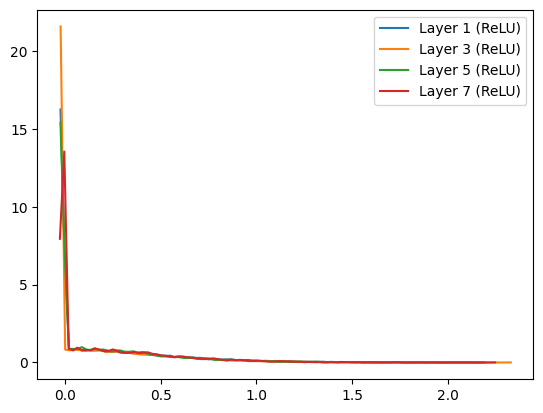

In [62]:
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, ReLU):
    t = layer.out
    x, y = torch.histogram(t.cpu(), density=True)
    plt.plot(y[:-1].cpu().detach(), x.cpu().detach())
    legends.append(f"Layer {i} ({layer.__class__.__name__})" )
plt.legend(legends)
plt.show()

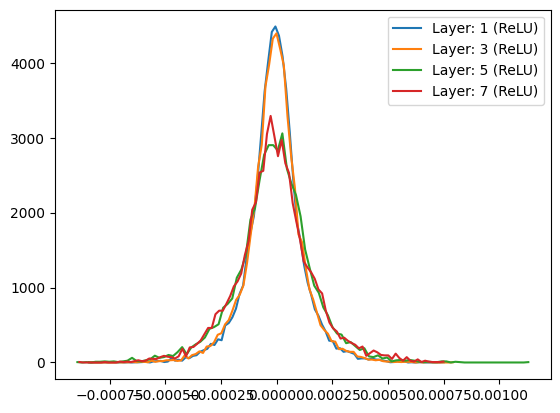

In [63]:
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, ReLU):
    t = layer.out.grad
    hy, hx = torch.histogram(t.cpu().detach(), density=True)
    plt.plot(hx[:-1].cpu().detach(), hy.cpu().detach())
    legends.append(f"Layer: {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.show()
